# 2022 Spring ORF307 Final Project {-}

Instructor: Bartolomeo Stellato

AI: Rajiv Sambharya, Irina Wang, Vinit Ranjan


---


## Instructions {-}

**Exam files**: the exam files are available to download as a `zip` at [this link](http://bit.ly/orf307fp).

**Date and time:** from May 5, 2022 at 00:01am to May 7, 2022 at 11:59pm.

- Total time after download: 24 hours. No late submissions allowed.


## Exam rules {-}

- You are allowed to use all course materials on the midterm (lecture notes, books, precept materials, code, and homeworks). But you cannot use internet to search for answers.

- You have to justify all your answers. If you use code from the course materials, you have to explain what each step means.

- You cannot communicate with anyone during the exam.

- No late submissions allowed. Make sure your submission goes through on time. You can resubmit as many times as you like until your time expires.

- The exam is to be submitted electronically on Gradescope before 11:59pm. Please follow the [\texttt{Gradescope guide}](https://gradescope-static-assets.s3-us-west-2.amazonaws.com/help/submitting_hw_guide.pdf) upload the PDF version of your exam.

- Please remember to write your name on the first page of your solutions. Right next to it, please write out and sign the following pledge: *"I pledge my honor that I have not violated the honor code or the rules specified by the instructor during this examination".*


---

# Honor Code
I pledge my honor that I have not violated the honor code or the rules specified by the instructor during this examination.

**Student's name:** 

---

In [ ]:
# Run this cell to install gurobi. 
# If you are on Colab you need to go to "Runtime" -> "Restart runtime" afterwards.
!pip install gurobipy   

In [1]:
import numpy as np
np.set_printoptions(precision=2)  # Print few decimal places
np.set_printoptions(suppress=True)  # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt
import networkx as nx

# Final exam

## Project management
Consider a *project management* problem with $n$ tasks and $m$ milestones. We model the problem with network where each arc describes a task and each milestone a node. Graph connections represent precedence relations: if arc $j$ enters node $i$ and arc $k$ exits node $i$, task $k$ cannot start before task $j$ is completed. Our network has two extra nodes:
- Node $1$ with only outgoing arcs describing tasks that can start immediately. 
- Node $m$ with only incoming arcs corresponding to the last tasks required to complete the project.

Each task $j$ has a known duration $d_j$ in minutes. For each node $j$ the decision variable $y_j$ is the maximum completion time of all tasks required for milestone $j$. In other words, for each task $j$ connected between nodes $i$ and $\ell$, we have
$$
y_i + d_j \le y_{\ell}.
$$

Our goal is to assign the optimal start time of each milestone to minimize the completion time of the entire project 
$$y_m - y_1.$$



1. Formulate the project management problem as a linear optimization problem over decisions  $y=(y_1,\dots,y_m)\in\mathbf{R}^{m}$ in terms of vector $e=(1,0,\dots,0,-1) \in \mathbf{R}^m$, vector $d=(d_1,\dots,d_n) \in \mathbf{R}^n$, and matrix $A\in\mathbf{R}^{m \times n}$ being the node-arc incidence matrix of the network defined as
$$
A_{ij} = \begin{cases}
1 & \text{if task $j$ starts at milestone $i$}\\
-1 & \text{if task $j$ ends at milestone $i$}\\
0 & \text{otherwise}.
\end{cases}
$$

The project management problem can be written as 
$$
\begin{array}{ll}
\text{minimize} & -e^Ty\\
\text{subject to} & A^Ty \le - d.
\end{array}
$$

2. Consider the matrix `A` and vector `d` given below. Formulate the network management problem in cvxpy and solve it. Print optimal primal solution $y^\star \in \mathbf{R}^{m}$,  optimal dual solution $x^\star \in \mathbf{R}^{n}$, and optimal objective. *Note.* To print dual optimal solutions, you can just select one constraints from your list and write `.dual_value`. For example, in case of constraint `0` you can simply write `constraint[0].dual_value`.

In [2]:
A = np.array([[ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
              [-1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
              [ 0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  1.,  1.,  0.,  0.],
              [ 0.,  0., -1.,  0.,  0.,  0.,  0., -1., -1.,  0.,  1.,  0.],
              [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1., -1.,  1.],
              [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])
m, n = A.shape
d = np.array([22., 29., 24., 22., 17., 26., 18., 36., 39., 15., 32., 21.])

In [3]:
def solve_project_management(A, d):
    
    # Extract data
    m, n = A.shape
    e = np.zeros(m)
    e[0] = 1
    e[-1] = -1
    
    # Formulate CVXPY problem
    y = cp.Variable(m)
    constraints = [A.T @ y + d <= 0]
    problem = cp.Problem(cp.Minimize(-e @ y), constraints)
    problem.solve()
    x_value = constraints[0].dual_value
    
    return y.value, x_value, problem.objective.value

y_sol, x_sol, obj_val = solve_project_management(A, d)
print("y = ", y_sol)
print("x = ", x_sol)
print("objective = ", obj_val)

y =  [-61.44 -37.09 -32.44 -13.27 -14.44  24.56  56.56  77.56]
x =  [0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
objective =  139.00000013141334


3. Derive the dual problem in terms of $x\in \mathbf{R}^{n}$.

The dual problem can be written as 
$$
\begin{array}{ll}
\text{maximize} & d^Tx\\
\text{subject to} & Ax = e\\
& x \ge 0.
\end{array}
$$

4. Consider the case when we have a faster machine to complete task $7$ such that the new time is $d_7 - 2$ (`d[6] - 2` in the code). How would the optimal objective change? Show it by solving the same problem with the function in point 2. Also, show that you can obtain the same results by looking at the dual solutions.

In [4]:
e = np.zeros(n)
e[6] = 2
d_new = d - e

x_new, y_new, obj_new = solve_project_management(A, d_new)
print("x = ", x_new)
print("y = ", y_new)
print("objective = %.2f" % obj_new)
print("obj_new - obj =  %.2f" % (obj_new - obj_val))

print("\nCost sensitivity for changes in d[6] = %.2f" % -x_sol[6])
print("obj_new - obj =  %.2f" % (-x_sol[6] * 2))

x =  [-60.14 -36.72 -31.14 -13.43 -15.14  23.86  55.86  76.86]
y =  [0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
objective = 137.00
obj_new - obj =  -2.00

Cost sensitivity for changes in d[6] = -1.00
obj_new - obj =  -2.00


5. Show that the dual problem corresponds to a minimum cost network flow problem. Solve the minimum cost network flow problem using cvxpy. Print the optimal solution `x_nf` and the optimal objective `obj_nf`.

In [5]:
def solve_min_cost_network_flow(A, d):
    # Extract data
    m, n = A.shape
    e = np.zeros(m)
    e[0] = 1
    e[-1] = -1
    
    # Formulate CVXPY problem
    x = cp.Variable(n)
    constraints = [A @ x == e, x >= 0]
    problem = cp.Problem(cp.Minimize(-d @ x), constraints)
    problem.solve()
    y_value = constraints[0].dual_value
    
    return x.value, y_value, problem.objective.value

x_nf, y_nf, obj_nf = solve_min_cost_network_flow(A, d)
print("x = ", x_nf)
print("objective = ", obj_nf)

x =  [ 0.  1. -0.  0.  0. -0.  1.  0.  1. -0.  1.  1.]
objective =  -139.00000018101895


The following function shows a graph of the resulting minimum cost flow solution `x` using `networkx`. It is not necessary to use it but it might help you visualize the solution.

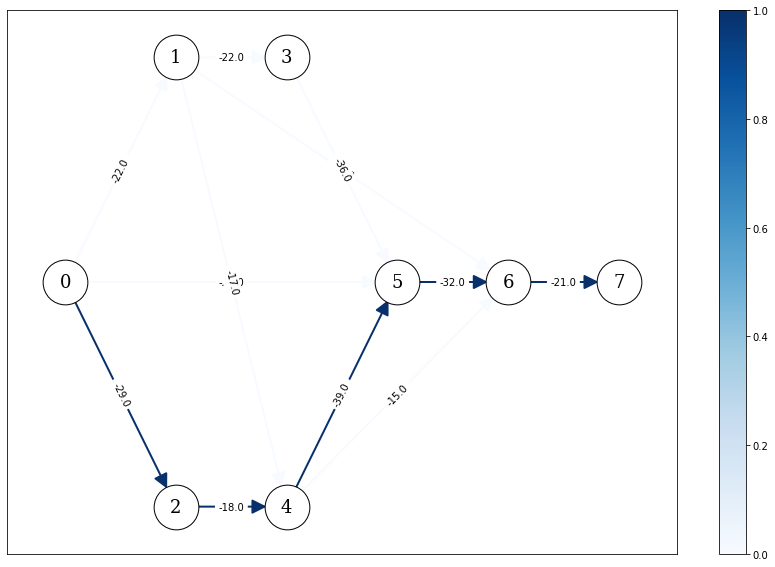

In [6]:
def show_optimal_solution(x, d):
    G = nx.DiGraph()

    # Add nodes
    G.add_nodes_from(range(8))

    # Add edges
    G.add_edge(0, 1, cost=-d[0])
    G.add_edge(0, 2, cost=-d[1])
    G.add_edge(0, 5, cost=-d[2])
    G.add_edge(1, 3, cost=-d[3])
    G.add_edge(1, 4, cost=-d[4])
    G.add_edge(1, 6, cost=-d[5])
    G.add_edge(2, 4, cost=-d[6])
    G.add_edge(3, 5, cost=-d[7])
    G.add_edge(4, 5, cost=-d[8])
    G.add_edge(4, 6, cost=-d[9])
    G.add_edge(5, 6, cost=-d[10])
    G.add_edge(6, 7, cost=-d[11])
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    cmap = plt.cm.Blues

    # Node positions in 2d plot
    layout = {0: np.array([0.0, 0.0]),
              1: np.array([0.5, 0.5]),
              2: np.array([0.5, -0.5]),
              3: np.array([1.0, 0.5]),
              4: np.array([1.0, -0.5]),
              5: np.array([1.5, 0.0]),
              6: np.array([2.0, 0.0]),
              7: np.array([2.5, 0.0]),
             }
    nx.draw_networkx_nodes(G, layout, node_color='w', edgecolors='k', node_size=2000)

    # Draw edges
    nx.draw_networkx_edges(G, layout, edge_cmap=cmap, edge_color=x, 
                           width=2, arrowsize=30, min_target_margin=20)

    # Print colormap
    sm = plt.cm.ScalarMappable(cmap=cmap, 
                               norm=plt.Normalize(vmin=0, vmax=1)
                              )
    cbar = plt.colorbar(sm)

    labels = {l:l for l in range(8)}
    nx.draw_networkx_labels(G, layout, labels, font_family='serif', font_size=18)
    
    # draw cost
    costs = nx.get_edge_attributes(G, "cost")

    nx.draw_networkx_edge_labels(G, layout, costs)

    plt.show()
    
show_optimal_solution(x_nf, d)

6. Which of special examples of minimum cost network flow does the dual problem correspond to? What is the cost associated to each arc? *Hint.* No need to specify upper bounds on $x$ since they are automatically satisfied in this case.

It corresponds to a shortest path problem where, at each arc $j$, the cost is $-d_j$.

7. Let's go back to the project management problem from point 1. Consider the case when the milestone times $y_j$ must be multiples of 15 minutes and $y_1 = 0$ (i.e., we start the project at time $0$. Formulate the problem as a mixed-integer optimization problem.

The project management problem with milestone times as multiples of 15 minutes can be written as 
$$
\begin{array}{ll}
\text{minimize} & -e^Ty\\
\text{subject to} & A^Ty \le - d\\
& y = 15 z\\
& y_1 = 0, z \in \mathcal{I}
\end{array}
$$

8. Solve the new project management problem. Print optimal solution and objective value. Compare the objective to the one from point 1. Which one is larger? Explain why.

In [7]:
def solve_project_management_integer(A, d):
    
    # Extract data
    m, n = A.shape
    e = np.zeros(m)
    e[0] = 1
    e[-1] = -1
    
    # Formulate CVXPY problem
    y = cp.Variable(m)
    z = cp.Variable(m, integer=True)
    constraints = [A.T @ y + d <= 0, 15 * z == y, y[0] == 0]
    problem = cp.Problem(cp.Minimize(-e @ y), constraints)
    problem.solve()
    x_value = constraints[0].dual_value
    
    return y.value, x_value, problem.objective.value

y_sol_int, x_sol_int, obj_val_int = solve_project_management_integer(A, d)
print("y = ", y_sol_int)
print("objective = ", obj_val_int)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-15
y =  [  0.  30.  30.  60.  60. 105. 150. 180.]
objective =  180.0


9. Our project was scheduled to complete within $1$ hour and $30$ minutes. However, we have a few milestones that cannot be completed on time. For each milestone that is above the supposed completion time (in minutes), we pay a price of $50$ mln USD. Adapt problem at point 7. to minimize the total project time plus the price we pay (in mln USD) for each milestone above the suppose completion time.

10. Solve the new problem in cvxpy. Print the optimal solution and objective value. Is the objective different than in point 8.? Is the solution different? Explain why.

In [8]:
def solve_project_management_integer_count(A, d):
    
    # Extract data
    m, n = A.shape
    e = np.zeros(m)
    e[0] = 1
    e[-1] = -1
    
    # Add counting variables
    w = cp.Variable(m, boolean=True)
    M = 300  # Big-M minutes
    
    # Formulate CVXPY problem
    y = cp.Variable(m)
    z = cp.Variable(m, integer=True)
    constraints = [A.T @ y + d <= 0, 
                   15 * z == y, 
                   y[0] == 0,
                   y - 90 <= M * w,
                   ]
    problem = cp.Problem(cp.Minimize(-e @ y + 50 * cp.sum(w)), constraints)
    problem.solve()
    x_value = constraints[0].dual_value
    
    return y.value, x_value, problem.objective.value

y_sol_int_count, x_sol_int_count, obj_val_int_count = solve_project_management_integer_count(A, d)
print("y = ", y_sol_int_count)
print("objective = ", obj_val_int_count)

y =  [  0.  30.  30.  60.  60. 105. 150. 180.]
objective =  330.0


---

In [9]:
# Get problem data
np.random.seed(0)

# execution times
d = np.rint(40 * np.random.rand(n))
d

array([22., 29., 24., 22., 17., 26., 18., 36., 39., 15., 32., 21.])

In [10]:
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(range(8))

# Add edges
G.add_edge(0, 1, cost=-d[0])
G.add_edge(0, 2, cost=-d[1])
G.add_edge(0, 5, cost=-d[2])
G.add_edge(1, 3, cost=-d[3])
G.add_edge(1, 4, cost=-d[4])
G.add_edge(1, 6, cost=-d[5])
G.add_edge(2, 4, cost=-d[6])
G.add_edge(3, 5, cost=-d[7])
G.add_edge(4, 5, cost=-d[8])
G.add_edge(4, 6, cost=-d[9])
G.add_edge(5, 6, cost=-d[10])
G.add_edge(6, 7, cost=-d[11])

In [11]:
# node arc incidence matrix
A = -nx.linalg.graphmatrix.incidence_matrix(G, oriented=True)
m, n = A.shape

In [12]:
A.toarray()

array([[ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0., -1., -1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

In [13]:
d

array([22., 29., 24., 22., 17., 26., 18., 36., 39., 15., 32., 21.])